In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

In [ ]:
!pip install findspark

In [ ]:
import findspark
findspark.init()


In [ ]:
findspark.find()

'/content/spark-3.0.3-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels

--2022-02-21 12:04:47--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  17.8MB/s    in 0.7s    

2022-02-21 12:04:48 (17.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
{"tunnels":[],"uri":"/api/tunnels"}


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install kaggle

In [ ]:
%cd /content/gdrive/MyDrive/DataSets/sna-hackathon-2019-data

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/DataSets/sna-hackathon-2019-data"

In [ ]:
!kaggle datasets download -d sharthz23/sna-hackathon-2019-collaboration

100% 2.16G/2.16G [00:47<00:00, 55.8MB/s]
100% 2.16G/2.16G [00:47<00:00, 49.4MB/s]


In [ ]:
%ls

kaggle.json  sna-hackathon-2019-collaboration.zip


In [ ]:
#!rm -rf  '/content/gdrive/MyDrive/DataSets/sna-hackathon-2019-data'

In [ ]:
!unzip sna-hackathon-2019-collaboration.zip -d sna-hackathon-2019-collaboration

Archive:  sna-hackathon-2019-collaboration.zip
replace sna-hackathon-2019-collaboration/test/_SUCCESS? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
ls

kaggle.json                        sna-hackathon-2019-collaboration.zip
sna-hackathon-2019-collaboration/


In [ ]:
data =spark.read.parquet("/content/gdrive/MyDrive/DataSets/sna-hackathon-2019-data/sna-hackathon-2019-collaboration/train")

In [ ]:
data.printSchema()

In [ ]:
from pyspark.sql.functions import col, array_contains
from pyspark.sql import Window
from pyspark.sql import functions as F

In [ ]:
data_fb_flag=data.withColumn('feedback_like',array_contains(col('feedback'), 'Liked'))

Задание 1. Постройте топ популярных групп для каждого типа обьекта

In [ ]:
data_fb_flag.createOrReplaceTempView("table1")

In [ ]:
task_1 = spark.sql("select instanceId_objectType,instanceId_objectId,count(1) as dest from table1 where feedback_like=1 group by 1,2 order by instanceId_objectType,instanceId_objectId")

In [ ]:
task_1.createOrReplaceTempView("v_task_1")

In [ ]:
task_1_fnl = spark.sql("select instanceId_objectType,instanceId_objectId, dest from (select instanceId_objectType,instanceId_objectId, dest, row_number() over (partition by instanceId_objectType order by dest desc) as seqnum from v_task_1 ) a where seqnum <= 3 order by dest desc")

In [ ]:
task_1_fnl.show(10)

+---------------------+-------------------+----+
|instanceId_objectType|instanceId_objectId|dest|
+---------------------+-------------------+----+
|                Video|             535842|1329|
|                Video|            1282812| 868|
|                Video|             603629| 822|
|                 Post|           19152905| 689|
|                 Post|           11300713| 660|
|                 Post|           38567725| 568|
|                Photo|            6537034| 215|
|                Photo|            7001118| 171|
|                Photo|            7474842| 152|
+---------------------+-------------------+----+



In [ ]:
task_1_v2 = data_fb_flag.groupBy('instanceId_objectType','instanceId_objectId','feedback_like').agg(F.count("instanceId_objectId").alias("dist")).filter(col('feedback_like')==1)

In [ ]:
task_1_v2.show(3)

+---------------------+-------------------+-------------+----+
|instanceId_objectType|instanceId_objectId|feedback_like|dist|
+---------------------+-------------------+-------------+----+
|                 Post|           34182627|         true|   1|
|                 Post|           38959811|         true|  89|
|                 Post|           31311616|         true|  41|
+---------------------+-------------------+-------------+----+
only showing top 3 rows



In [ ]:
windowspec = Window.partitionBy("instanceId_objectType").orderBy(F.desc("dist"))

In [ ]:
task_1_v2_fnl = task_1_v2.withColumn("dense_rank", F.dense_rank().over(windowspec)).filter(col('dense_rank')<4)


In [ ]:
task_1_v2_fnl.show(10)

+---------------------+-------------------+-------------+----+----------+
|instanceId_objectType|instanceId_objectId|feedback_like|dist|dense_rank|
+---------------------+-------------------+-------------+----+----------+
|                Video|             535842|         true|1329|         1|
|                Video|            1282812|         true| 868|         2|
|                Video|             603629|         true| 822|         3|
|                Photo|            6537034|         true| 215|         1|
|                Photo|            7001118|         true| 171|         2|
|                Photo|            7474842|         true| 152|         3|
|                 Post|           19152905|         true| 689|         1|
|                 Post|           11300713|         true| 660|         2|
|                 Post|           38567725|         true| 568|         3|
+---------------------+-------------------+-------------+----+----------+



Задание 2. Построите гистограммы популярности/активности по времени суток

In [ ]:
data_fb_flag.select("feedback_like","audit_timestamp").filter(F.col("feedback_like")==1).show()

+-------------+---------------+
|feedback_like|audit_timestamp|
+-------------+---------------+
|         true|  1520194086477|
|         true|  1520113126655|
|         true|  1520181187538|
|         true|  1520149355325|
|         true|  1520149355325|
|         true|  1520180361924|
|         true|  1520113922708|
|         true|  1520164661139|
|         true|  1520186535836|
|         true|  1520191561935|
|         true|  1520189246050|
|         true|  1520147319795|
|         true|  1520165001983|
|         true|  1520189565974|
|         true|  1520179406432|
|         true|  1520145890861|
|         true|  1520196590526|
|         true|  1520184400395|
|         true|  1520174875202|
|         true|  1520182308084|
+-------------+---------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import date_format

In [ ]:
data_for_hist=data_fb_flag\
.withColumn("TimestampType",F.from_unixtime(data_fb_flag["audit_timestamp"]/1000,"yyyy-MM-dd HH:mm:ss"))\
.withColumn("hour",F.hour("TimestampType"))\
.filter(F.col("feedback_like")==1)

In [ ]:
data_for_hist.groupBy('hour').agg(F.count("*").alias("dist")).show()

+----+------+
|hour|  dist|
+----+------+
|  12|169721|
|  22| 40591|
|   1| 47631|
|  13|179310|
|  16|216801|
|   6|148278|
|   3| 92829|
|  20|111482|
|   5|141120|
|  19|160212|
|  15|207219|
|  17|216800|
|   9|153337|
|   4|119202|
|   8|151691|
|  23| 32854|
|   7|150529|
|  10|157624|
|  21| 65216|
|  11|161601|
+----+------+
only showing top 20 rows



In [ ]:
task_2 = data_for_hist.groupBy('hour').agg(F.count("*").alias("dist"))

In [ ]:
gre_histogram = data_for_hist.select('hour').rdd.flatMap(lambda x: x).histogram(24)

In [ ]:
import pandas as pd

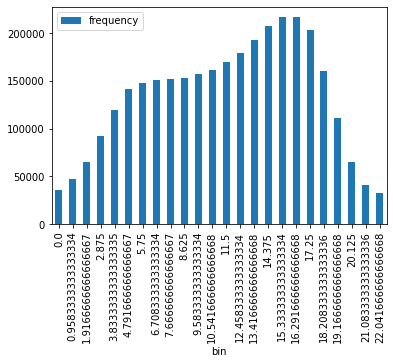

In [ ]:
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [ ]:
pip install spark-plot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 281.4 MB 39 kB/s 
     |████████████████████████████████| 198 kB 68.9 MB/s 
  Created wheel for spark-plot: filename=spark_plot-0.0.1-py2.py3-none-any.whl size=9077 sha256=0bc02fd38d2b596c29bac48db1d75662481e40c7b59a9f1578b2374f7543eea8
  Stored in directory: /root/.cache/pip/wheels/90/41/34/aebde12a852c190d712439080a1b7674def7d568047acc5e29
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=47fbe36994729dabbc17edc450ed176ab98c43a784c64f22bf1923af9c54895c
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built spark-plot pyspark


In [ ]:
from spark_plot import mpl

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cf63cb890>],
      dtype=object)

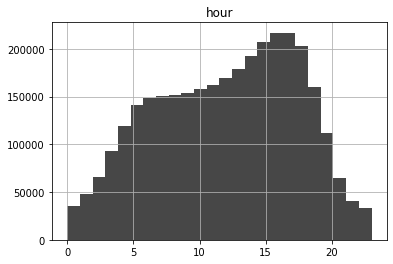

In [ ]:
mpl.hist(data_for_hist, "hour", color="#474747")

Посчитайте корреляцию признаков с целевой переменной

In [ ]:
from pyspark.sql.types import StringType, DoubleType, IntegerType, LongType, BooleanType

In [ ]:
data_fb_flag.printSchema()

In [ ]:
dbl_cols = [f.name for f in data_fb_flag.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, LongType,BooleanType))]

In [ ]:
dbl_cols

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *


In [ ]:
type(dbl_cols)

list

In [ ]:
dbl_cols.columns

In [ ]:
#dataset_corr= data_fb_flag.select([col for col in dbl_cols])

In [ ]:
assembler = VectorAssembler(inputCols=dbl_cols,outputCol="features",handleInvalid='keep')

In [ ]:
df = assembler.transform(data_fb_flag).select("features")

In [ ]:
pearsonCorr = Correlation.corr(df,"features","pearson").collect()[0][0]

In [ ]:
pearsonCorr_rows = pearsonCorr.toArray().tolist()
df_pearsonCorr = spark.createDataFrame(pearsonCorr_rows,dbl_cols)

In [ ]:
df_pearsonCorr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------+----------------------------------+-----------------------------------+---------------------------+-----------------------------------+-------------------------------------+------------------------------------+--------------------------------------+--------------------------------------------+--------------------------------------+--------------------------------------+-------------------------------------------------+---------------------------------------+-------------------------------------------+-----------------------------------+----------------------------+----------------------------------------+-------

In [ ]:
spearmanCorr = Correlation.corr(df,"features","spearman").collect()[0][0]

In [ ]:
spearmanCorr_rows = pearsonCorr.toArray().tolist()
df_spearmanCorr = spark.createDataFrame(spearmanCorr_rows,dbl_cols)